In [2]:
import cv2
import dlib
print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


# Step 1. 스티커 구하기 or 만들기

In [38]:
import os

my_image_path = './data'
os.listdir(my_image_path)

['.ipynb_checkpoints', 'cat-whiskers.png', '좌측셀카.jpg', '우측셀카.jpg', '정면셀카.jpg']

# Step 2. 얼굴 검출 & 랜드마크 검출하기

In [6]:
# dlib을 이용해서 얼굴의 bouding box 위치와 landmark의 위치를 찾아주세요.

In [7]:
# 필요한 패키지 import 하기
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

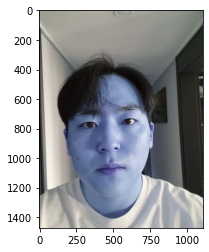

In [78]:
img_bgr = cv2.imread(os.path.join(my_image_path, '정면셀카.jpg'))    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
plt.imshow(img_bgr) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
plt.show() # 이미지를 출력해준다. (실제 출력)

# BGR이라 아바타처럼 보임

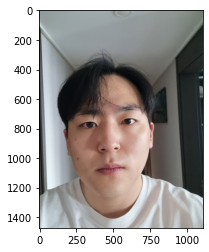

In [40]:
# plt.imshow 이전에 RGB 이미지로 바꾸는 것을 잊지마세요. 
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb) # 이미지 실제 출력하기 위해 이미지를 올려줌 (원하는 사이즈의 픽셀을 원하는 색으로 채워서 만든 그림이라고 합니다.)
plt.show() # 이미지 실제 출력

In [41]:
# detector를 선언합니다
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기를 반환

In [42]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   # (image, num of image pyramid)

rectangles[[(132, 576) (798, 1242)]]


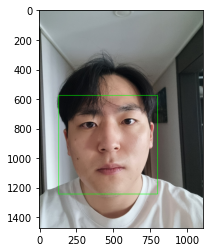

In [80]:
# 찾은 얼굴 영역 박스 리스트
# 여러 얼굴이 있을 수 있습니다
print(dlib_rects)   

for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표 , 여러개 있을 수도 있어서 for문 돌림
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# Step 3. 스티커 적용 위치 확인하기

In [25]:
# !wget http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
# !mv shape_predictor_68_face_landmarks.dat.bz2 ~/aiffel/camera_sticker/models
# !cd ~/aiffel/camera_sticker && bzip2 -d ./models/shape_predictor_68_face_landmarks.dat.bz2

--2023-10-04 01:29:04--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  14.3MB/s    in 7.7s    

2023-10-04 01:29:12 (7.88 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]

bzip2: Output file ./models/shape_predictor_68_face_landmarks.dat already exists.


In [44]:
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
    # 저장한 landmark 모델의 주소를 model_path 변수에 저장
landmark_predictor = dlib.shape_predictor(model_path)
    # dlib 라이브러리의 shape_predictor 함수를 이용하여 모델을 불러옴
    # landmark_predictor는 RGB이미지와 dlib.rectangle를 입력 받고 dlib.full_object_detection를 반환
    # dlib.rectangle: 내부를 예측하는 박스
    # dlib.full_object_detection: 각 구성 요소의 위치와, 이미지 상의 객체의 위치를 나타냄

In [45]:
list_landmarks = []
    # 랜드마크의 위치를 저장할 list 생성    

# top-down 방식 사용. landmark 구했고 -> 점 찍기
    
# 얼굴 영역 박스 마다 face landmark를 찾아냅니다
# face landmark 좌표를 저장해둡니다
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
        # 모든 landmark의 위치정보를 points 변수에 저장
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        # 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
    list_landmarks.append(list_points)
        # list_landmarks에 랜드마크 리스트를 저장

print(len(list_landmarks[0]))
    # 얼굴이 n개인 경우 list_landmarks는 n개의 원소를 갖고
    # 각 원소는 68개의 랜드마크 위치가 나열된 list 
    # list_landmarks의 원소가 1개이므로 list_landmarks[1]을 호출하면 IndexError가 발생

68


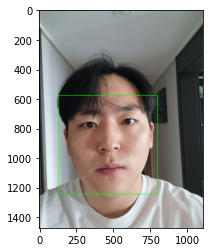

In [85]:
# 코 끝 위치 확인하기

cv2.circle(img_show, list_landmarks[0][33], 5, (0, 255, 255), -1)
# 코 끝의 indexs는 33으로 고정되어있음.

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

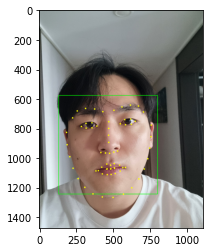

In [86]:
# list_landmarks의 원소가 1개이므로 아래 반복문은 한번만 실행됨
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
    # RGB 이미지로 전환
plt.imshow(img_show_rgb)
    # 이미지를 준비
plt.show()
    # 이미지를 출력

# Step 4. 스티커 적용하기

In [264]:
# zip() : 두 그룹의 데이터를 서로 엮어주는 파이썬의 내장 함수
# dlib_rects와 list_landmarks 데이터를 엮어 주었음

# dlib_rects : 얼굴 영역을 저장하고 있는 값
# → rectangles[(132, 576) (798, 1242)]

# list_landmarks : 68개의 랜드마크 값 저장(이목구비 위치(x,y))
# -> [[(185, 826), (189, 909), (207, 990), (229, 1068), (263, 1138), (308, 1197), (363, 1241), (426, 1262), (498, 1265), (568, 1243), (624, 1200), (672, 1140), (708, 1073), (732, 1004), (745, 932), (754, 855), (755, 777), (226, 728), (257, 681), (313, 664), (374, 668), (429, 686), (504, 677), (558, 654), (615, 642), (669, 648), (703, 688), (469, 754), (469, 799), (468, 845), (469, 893), (416, 962), (447, 965), (475, 967), (503, 959), (529, 952), (285, 786), (316, 765), (356, 761), (389, 783), (356, 795), (317, 797), (547, 768), (577, 740), (617, 736), (647, 751), (621, 771), (582, 774), (383, 1086), (422, 1061), (456, 1040), (481, 1047), (506, 1037), (542, 1047), (581, 1063), (546, 1087), (513, 1104), (485, 1110), (459, 1111), (426, 1106), (399, 1084), (458, 1072), (483, 1072), (508, 1066), (564, 1064), (507, 1068), (482, 1073), (456, 1074)]]

for dlib_rect, landmark in zip(dlib_rects, list_landmarks): # 얼굴 영역을 저장하고 있는 값과 68개의 랜드마크를 저장하고 있는 값으로 반복문 실행
    print (landmark[33]) # 코끝의 index는 30
    x = landmark[33][0] # 이미지에서 코 끝 부위의 x값
    y = landmark[33][1] # 이미지에서 코 끝 부위의 y값
    w = h = dlib_rect.width() # 얼굴 영역의 가로를 차지하는 픽셀의 수 (531 - 345 + 1) → max(x) - min(x) +1(픽셀의 수 이기 때문에 1을 더해줌 → 픽셀 수는 점 하나로도 1이 됨)
    print (f'(x,y) : ({x},{y})')
    print (f'(w,h) : ({w},{h})')

(475, 967)
(x,y) : (475,967)
(w,h) : (667,667)


In [265]:
# sticker_path = os.getenv('HOME')+'/aiffel/camera_sticker/images/king.png' # 왕관 이미지의 경로

# 고양이 스티커 경로
sticker_path = './data/cat-whiskers.png'
img = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환

# img_sticker = img[:,:, :3]
img_sticker = img

print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확인
img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))
print (img_sticker.shape) # 사이즈를 조정한 왕관 이미지의 차원 확

(512, 512, 4)
(667, 667, 4)


(x,y) : (142,634)


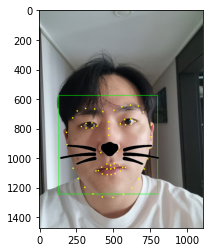

In [269]:
# 반복해서 그려볼 수 있도록 위에서 했던 것들 반복
img_show = cv2.imread(os.path.join(my_image_path, '정면셀카.jpg'))    # OpenCV로 이미지를 불러옵니다

# 스티커랑 차원 수를 맞춰주기 위해서
new_array = np.zeros((img_show.shape[0], img_show.shape[1], 4), dtype=np.uint8)
new_array[..., :3] = img_show
new_array[..., 3] = 255

img_show = new_array


for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표 , 여러개 있을 수도 있어서 for문 돌림
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림

for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 5, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
# -----------------------------------------------------------------------------------------------
            
# 스티커가 시작해야하는 위치를 지정
# 코 위치에서 넓이의 반만큼 왼쪽에서 시작
# 코 위치에서 높이
refined_x = x - w // 2 
refined_y = y - h // 2

#음수값 만큼 crop해주기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 좌표 순서가 y,x임에 유의. 
# -> (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

(x,y) : (142,634)


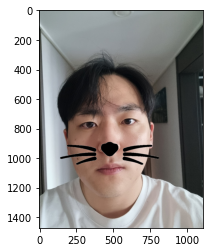

In [270]:
# 반복해서 그려볼 수 있도록 위에서 했던 것들 반복
img_show = cv2.imread(os.path.join(my_image_path, '정면셀카.jpg'))    # OpenCV로 이미지를 불러옵니다

new_array = np.zeros((img_show.shape[0], img_show.shape[1], 4), dtype=np.uint8)
new_array[..., :3] = img_show
new_array[..., 3] = 255

img_show = new_array

# -----------------------------------------------------------------------------------------------
            
# 스티커가 시작해야하는 위치를 지정
# 코 위치에서 넓이의 반만큼 왼쪽에서 시작
# 코 위치에서 높이
refined_x = x - w // 2 
refined_y = y - h // 2

#음수값 만큼 crop해주기
if refined_x < 0: 
    img_sticker = img_sticker[:, -refined_x:]
    refined_x = 0
if refined_y < 0:
    img_sticker = img_sticker[-refined_y:, :]
    refined_y = 0

print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

# sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
# 좌표 순서가 y,x임에 유의. 
# -> (y,x,rgb channel)
# img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

# 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
# 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
# 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
# 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
# sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
# 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
# 나머지 부분은 스티커로 채워주면 됨
# np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
# 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
# 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

In [275]:
def add_sticker(img_path):
    # 반복해서 그려볼 수 있도록 위에서 했던 것들 반복
    img_show = cv2.imread(img_path)    # OpenCV로 이미지를 불러옵니다

    new_array = np.zeros((img_show.shape[0], img_show.shape[1], 4), dtype=np.uint8)
    new_array[..., :3] = img_show
    new_array[..., 3] = 255

    img_show = new_array
    
    # 고양이 스티커 경로
    sticker_path = './data/cat-whiskers.png'
    img = cv2.imread(sticker_path, cv2.IMREAD_UNCHANGED) # 스티커 이미지를 불러옵니다 // cv2.imread(이미지 경로) → image객체 행렬을 반환

    # img_sticker = img[:,:, :3]
    img_sticker = img
    img_sticker = cv2.resize(img_sticker, (w,h)) # 스티커 이미지 조정 → w,h는 얼굴 영역의 가로를 차지하는 픽셀의 수(187) // cv2.resize(image객체 행렬, (가로 길이, 세로 길이))

    # -----------------------------------------------------------------------------------------------

    # 스티커가 시작해야하는 위치를 지정
    # 코 위치에서 넓이의 반만큼 왼쪽에서 시작
    # 코 위치에서 높이
    refined_x = x - w // 2 
    refined_y = y - h // 2
    
    
    
    #음수값 만큼 crop해주기
    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0

    print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

    # sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 입니다.
    # 좌표 순서가 y,x임에 유의. 
    # -> (y,x,rgb channel)
    # img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]

    # 왕관 이미지에서 사용할 부분은 0이 아닌 색이 있는 부분을 사용합니다.
    # 왕관 이미지에서 0이 나오는 부분은 흰색이라는 뜻, 즉 이미지가 없다는 소리임.
    # 현재 왕관 이미지에서는 왕관과 받침대 밑의 ------ 부분이 됨
    # 그렇기 때문에 0인 부분(이미지가 없는 부분)은 제외하고 적용
    # sticker_area는 원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지입니다.
    # 즉, 왕관 이미지에서 왕관 이미지가 없는 부분(왕관과 받침대 밑의 ------ 부분)은 원본 이미지에서 미리 잘라놓은 sticker_area(스티커 적용할 부분 만큼 원본 이미지에서 자른 이미지)를 적용하고,
    # 나머지 부분은 스티커로 채워주면 됨
    # np.where는 조건에 해당하는 인덱스만 찾아서 값을 적용하는 방법이다.
    # 아래 코드에서는 img_sticker가 0일 경우(왕관 이미지에서 왕관 부분 제외한 나머지 이미지)에는 sticker_area(원본 이미지에서 스티커를 적용할 위치를 미리 잘라낸 이미지)를 적용하고,
    # 나머지 부분은 img_sticker(왕관 이미지)를 적용한다.
    img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
        np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

    plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
    plt.show()

# Step 5. 문제점 찾아보기

In [271]:
# 다양한 각도에서 적용해보기

In [273]:
import os

os.listdir('./data')

['.ipynb_checkpoints', 'cat-whiskers.png', '좌측셀카.jpg', '우측셀카.jpg', '정면셀카.jpg']

(x,y) : (142,634)


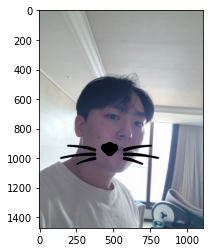

(x,y) : (142,634)


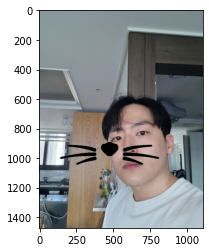

(x,y) : (142,634)


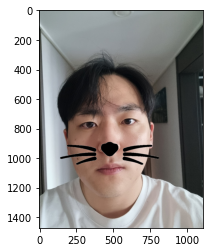

In [277]:
photos = ['좌측셀카', '우측셀카', '정면셀카']
for photo in photos:
    add_sticker(f'./data/{photo}.jpg')

- 코 위치와 좌우 폭을 기준으로 고양이 스티커의 시작점을 정했기 때문에 각도를 바꾸면 정확히 위치하지 않는다. 
- 즉, 얼굴이 중앙에 위치할 때를 기준으로 값을 설정헀기 때문에 가운데에 위치하지 않을 때 문제가 생긴다. (bounding box 기준으로)